# Overview

Problem Approach:
The give data on predicting corrosion rate of carbon steel contains features such as
1. Temperature 
2. Time of wetness  
3. sulfur dioxide 
4. chloride concentrations 
5. Exposure Time (Years)
and doesn't contain two features "Relative humidity and precipitation " 

Models Used
* [Lasso Regression](#Lasso-Regression)
* [Ridge Regression](#Ridge-Regression)
* [PCA with Ridge Regression](#PCA-with-Ridge-Regression)
* [Regression Trees](#Regression-Trees)
* [XG Boost with Regression](#XG-Boost-with-Regression)
* [ANN](#A-N-N)


Out of these models the XG Boost comes out to be the best model (with the R2 of 98.8% and 84.2% for training and testing datasets respectively)

Summary:
 1. The data is pretty clean with no missing values there aren't many outliers as well
 2. The distribution of target variable is skewed which is some what corrected by applying log transformation
 3. The Simple models of Lasso and Ridge reression gave moderate R2 values
 4. The PCA is applied and as expected the performance is dropped, this is due to the low number of indipendent
    variables and they are condensed into only single PCA component, so the loss of information  accounted for the
    drop in the performance
 5. So Regression tree is employed, The simple Regression tree got proned to overfitting with training value of 1 and
    test value of 0.52, so hyper parameter tuning is done, but the performance didn't improve much compared to
    previou models
 6. Later XG boost with parameter tuning is applied and the model performed significantly well then the rest
 7. The ANN model though comparatively better than others is not as good as the XG boost
 
 But overall all the models colud be improved with more number of features such as Humidity and Precipitation 

### Import all the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

from sklearn.metrics import r2_score

from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score,precision_score,recall_score,f1_score
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

from sklearn.tree import DecisionTreeRegressor

import xgboost

from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_excel('Corrosion data.xlsx')

In [3]:
df.head()

,Unnamed: 0,Temp©,TOW(%),SO2 (microgm/m^3),Cl-(mg/m^2/day),Exposure Time (Years),Corrosion depth in steel (mm)
0,1,13.34,0.16,65,182.0,3.0,88.7
1,2,13.34,0.16,65,182.0,2.0,79.2
2,3,13.34,0.16,26,182.0,3.0,95.1
3,4,13.34,0.16,26,182.0,2.0,81.0
4,5,13.34,0.16,26,182.0,1.0,48.1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 7 columns):
Unnamed: 0                       304 non-null int64
Temp©                            304 non-null float64
TOW(%)                           304 non-null float64
SO2 (microgm/m^3)                304 non-null int64
Cl-(mg/m^2/day)                  304 non-null float64
Exposure Time (Years)            304 non-null float64
Corrosion depth in steel (mm)    304 non-null float64
dtypes: float64(5), int64(2)
memory usage: 16.8 KB


In [5]:
df = df.drop(df.columns[0], axis=1)
df = df.rename(columns = {"Temp©":"temp","TOW(%)":"time of wetness"}, inplace = False)

In [6]:
df.describe()

,temp,time of wetness,SO2 (microgm/m^3),Cl-(mg/m^2/day),Exposure Time (Years),Corrosion depth in steel (mm)
count,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000
mean,10.737105,0.416569,30.009868,28.403586,3.218750,78.134211
std,6.381478,0.133032,32.700409,38.775464,2.577001,71.028911
min,0.310000,0.100000,2.000000,0.160000,0.500000,1.600000
25%,6.060000,0.360000,6.000000,5.000000,1.000000,33.550000
50%,7.580000,0.400000,20.000000,17.000000,2.000000,55.350000
75%,13.340000,0.480000,35.000000,31.000000,4.000000,95.100000
max,27.880000,0.950000,140.000000,182.000000,12.000000,411.100000


## EDA for checking correlations and distibution

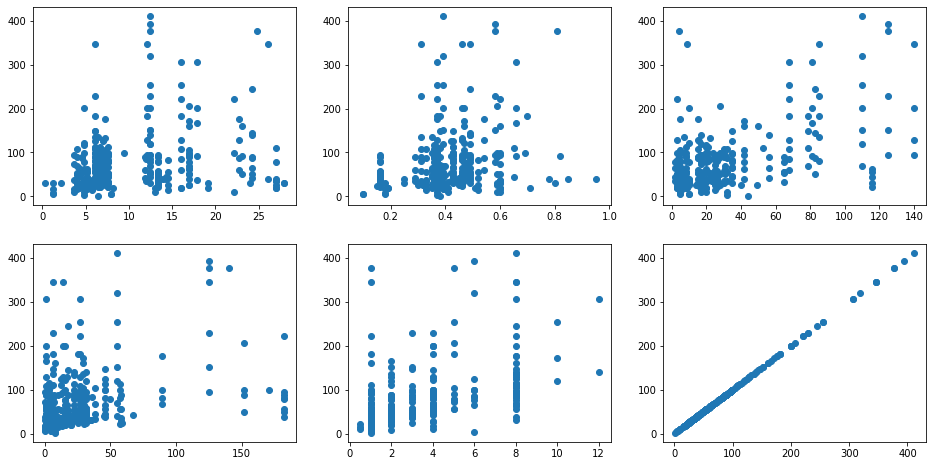

In [7]:
plt.figure(figsize=(16,8))
plt.subplot(2,3,1)
plt.scatter(df.temp,df["Corrosion depth in steel (mm)"])
plt.subplot(2,3,2)
plt.scatter(df["time of wetness"],df["Corrosion depth in steel (mm)"])
plt.subplot(2,3,3)
plt.scatter(df["SO2 (microgm/m^3)"],df["Corrosion depth in steel (mm)"])
plt.subplot(2,3,4)
plt.scatter(df["Cl-(mg/m^2/day)"],df["Corrosion depth in steel (mm)"])
plt.subplot(2,3,5)
plt.scatter(df["Exposure Time (Years)"],df["Corrosion depth in steel (mm)"])
plt.subplot(2,3,6)
plt.scatter(df["Corrosion depth in steel (mm)"],df["Corrosion depth in steel (mm)"])

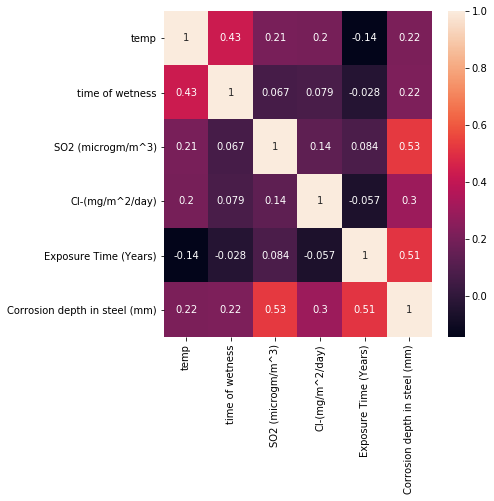

In [8]:
plt.figure(figsize=(6,6))
ax = sns.heatmap(df.corr(),annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

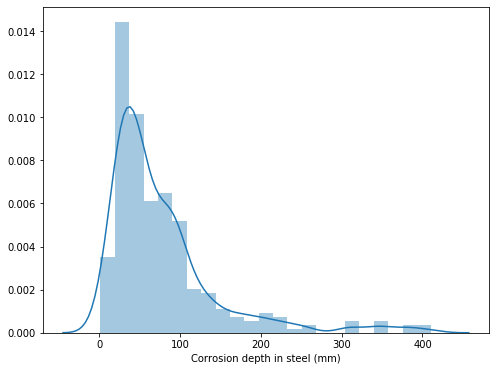

In [9]:
plt.figure(figsize=(8,6))
sns.distplot(df["Corrosion depth in steel (mm)"])
plt.show()

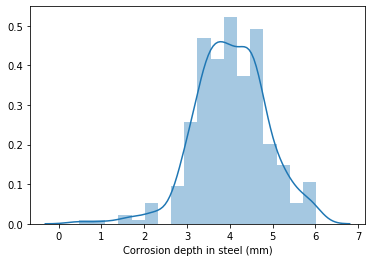

In [10]:
sns.distplot(np.log(df["Corrosion depth in steel (mm)"]))

## Data Preparation

In [11]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [12]:
df = df.apply(cap_outliers, axis=0)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [13]:
df

,temp,time of wetness,SO2 (microgm/m^3),Cl-(mg/m^2/day),Exposure Time (Years),Corrosion depth in steel (mm)
0,13.34,0.16,65.0,144.729977,3.0,88.7
1,13.34,0.16,65.0,144.729977,2.0,79.2
2,13.34,0.16,26.0,144.729977,3.0,95.1
3,13.34,0.16,26.0,144.729977,2.0,81.0
4,13.34,0.16,26.0,144.729977,1.0,48.1
...,...,...,...,...,...,...
299,17.88,0.66,81.0,0.800000,4.0,200.3
300,5.15,0.39,5.0,0.700000,2.0,26.0
301,5.15,0.37,116.0,0.620000,5.0,55.9
302,5.15,0.37,116.0,0.620000,0.5,21.0


In [14]:
df["Corrosion depth in steel (mm)"] = np.log(df["Corrosion depth in steel (mm)"])

In [15]:
X = df.drop(["Corrosion depth in steel (mm)"], axis=1).values
y = df["Corrosion depth in steel (mm)"].values

In [16]:
# split into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.7,test_size = 0.3, random_state=100)

In [17]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model 2: Ridge Regression <a class="anchor" id="Ridge-Regression"></a>

In [18]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

In [19]:
# Applying Ridge
ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.2s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [20]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=200]
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.003661,0.006162,0.000328,0.000081,0.0001,{'alpha': 0.0001},-0.314895,-0.298309,-0.488021,-0.384987,...,-0.369493,0.066940,14,-0.371040,-0.378662,-0.315839,-0.354638,-0.348530,-0.353742,0.021839
1,0.000433,0.000014,0.000260,0.000006,0.001,{'alpha': 0.001},-0.314896,-0.298301,-0.488020,-0.384987,...,-0.369489,0.066942,13,-0.371036,-0.378659,-0.315834,-0.354636,-0.348530,-0.353739,0.021840
2,0.000444,0.000039,0.000255,0.000010,0.01,{'alpha': 0.01},-0.314906,-0.298218,-0.488015,-0.384989,...,-0.369450,0.066959,12,-0.370994,-0.378630,-0.315790,-0.354612,-0.348528,-0.353711,0.021842
3,0.000397,0.000029,0.000233,0.000017,0.05,{'alpha': 0.05},-0.314949,-0.297854,-0.487992,-0.385000,...,-0.369278,0.067035,11,-0.370849,-0.378524,-0.315613,-0.354508,-0.348521,-0.353603,0.021856
4,0.000358,0.000013,0.000214,0.000002,0.1,{'alpha': 0.1},-0.315002,-0.297402,-0.487964,-0.385013,...,-0.369065,0.067131,10,-0.370692,-0.378410,-0.315424,-0.354390,-0.348533,-0.353490,0.021869


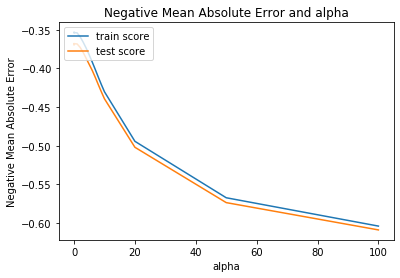

In [21]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [22]:
model_cv.best_params_

{'alpha': 0.7}

In [23]:
alpha = 0.7
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([0.50405882, 0.69684202, 1.0121902 , 0.79128112, 1.78748804])

In [24]:
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

print(r2_score(y_true=y_train,y_pred=y_train_pred))
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.6112023337192511
0.5574783133596108


## Model 3: PCA with Ridge Regression <a class="anchor" id="PCA-with-Ridge-Regression"></a>

In [25]:
## A method to perform PCA.  
## This method can be used to identify the number of components that can explain the required variance
def performPCA(X_train):
    pca = PCA(random_state=42)
    pca.fit(X_train)

    var_cumu = np.cumsum(pca.explained_variance_ratio_)    
    print("Cumulative explained_variance_ratio: \n",var_cumu)
    print('-'*80)
    print("Scree plot for the PCA")   
    
    plt.figure(figsize=[12,8])
    plt.plot(var_cumu)
    plt.hlines(y=0.95,xmax=150,xmin=0,colors="g",linestyles="--")
    plt.ylabel("Cumulative variance explained")
    plt.show()
    print("-"*80)
    return

In [26]:
## A Method to transform the dataset into the components that explain the required persistence
## This method is used to transform the test and train datasets
def buildPCA (X_train,X_test,varianceRatio):
    pca = PCA(varianceRatio)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca
    

#### 1. PCA on actual data

Cumulative explained_variance_ratio: 
 [0.31312131 0.56039157 0.75166005 0.91925613 1.        ]
--------------------------------------------------------------------------------
Scree plot for the PCA


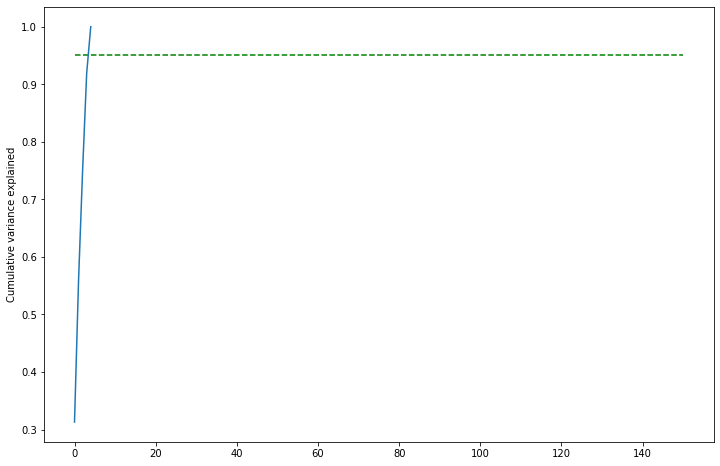

--------------------------------------------------------------------------------


In [27]:
## Perform PCA on actual data

performPCA(X_train)

In [28]:
## Build PCA on actual data

X_train_pca1,X_test_pca1 = buildPCA(X_train,X_test,1)

#### A. Ridge Regression 

In [29]:
# Applying Ridge
ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train_pca1, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.2s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [30]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=200]
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.000800,0.000436,0.000322,0.000041,0.0001,{'alpha': 0.0001},-0.510517,-0.438687,-0.652030,-0.628362,...,-0.562734,0.078550,1,-0.568825,-0.586627,-0.537376,-0.537541,-0.550257,-0.556125,0.019094
1,0.000687,0.000061,0.000381,0.000078,0.001,{'alpha': 0.001},-0.510517,-0.438688,-0.652039,-0.628360,...,-0.562736,0.078551,2,-0.568827,-0.586628,-0.537378,-0.537543,-0.550258,-0.556127,0.019094
2,0.000405,0.000065,0.000267,0.000042,0.01,{'alpha': 0.01},-0.510509,-0.438699,-0.652130,-0.628338,...,-0.562755,0.078567,3,-0.568846,-0.586643,-0.537389,-0.537560,-0.550270,-0.556142,0.019096
3,0.000826,0.000177,0.000383,0.000093,0.05,{'alpha': 0.05},-0.510477,-0.438747,-0.652529,-0.628243,...,-0.562840,0.078637,4,-0.568933,-0.586710,-0.537438,-0.537635,-0.550346,-0.556212,0.019099
4,0.000414,0.000013,0.000259,0.000007,0.1,{'alpha': 0.1},-0.510436,-0.438806,-0.653025,-0.628125,...,-0.562944,0.078724,5,-0.569042,-0.586793,-0.537499,-0.537729,-0.550442,-0.556301,0.019104


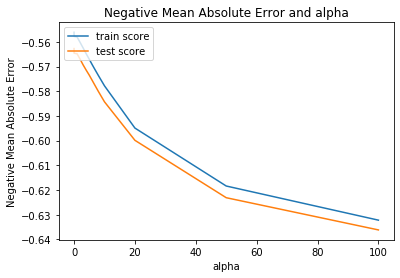

In [31]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [32]:
model_cv.best_params_

{'alpha': 0.0001}

In [33]:
alpha = 0.0001
ridge = Ridge(alpha=alpha)

ridge.fit(X_train_pca1, y_train)
ridge.coef_

array([1.51428665])

In [34]:
y_train_pred = ridge.predict(X_train_pca1)
y_test_pred = ridge.predict(X_test_pca1)

print(r2_score(y_true=y_train,y_pred=y_train_pred))
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.27156391194125695
0.14588426745690475


In [35]:
Train2 = pd.DataFrame(y_train,y_train_pred)
Train2.reset_index(level=0, inplace=True)
Train2 = Train2.rename(columns = {'index': 'y train', 0: 'y train pred'}, inplace = False)

In [36]:
Test2 = pd.DataFrame(y_test,y_test_pred)
Test2.reset_index(level=0, inplace=True)
Test2 = Test2.rename(columns = {'index': 'y test', 0: 'y test pred'}, inplace = False)

In [37]:
Train2

,y train,y train pred
0,3.712648,4.603168
1,3.899330,3.058707
2,3.895132,4.603168
3,3.670970,3.437208
4,4.599678,4.394449
...,...,...
207,4.061860,4.003690
208,4.588593,3.407842
209,4.351053,4.371976
210,3.972845,4.350278


In [38]:
Test2

,y test,y test pred
0,3.563983,4.462454
1,4.372533,3.910021
2,4.766528,4.603168
3,3.500096,3.532226
4,3.738768,3.985273
...,...,...
87,3.677828,4.023564
88,3.492782,4.160444
89,4.588593,3.407842
90,3.893453,4.727388


In [41]:
import openpyxl
from openpyxl import load_workbook

In [42]:
workbook = openpyxl.load_workbook("multiple.xlsx")
writer = pd.ExcelWriter('multiple.xlsx', engine='openpyxl')
writer.book = workbook
writer.sheets = dict((ws.title, ws) for ws in workbook.worksheets)
Train2.to_excel(writer, sheet_name='Train2')
Test2.to_excel(writer, sheet_name='Test2')
writer.save()

In [ ]:
writer = pd.ExcelWriter('multiple.xlsx', engine='xlsxwriter')

Train2.to_excel(writer, sheet_name='Train2')

Test2.to_excel(writer, sheet_name='Test2')

writer.save()